In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
#plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold, cross_val_score

# 평가함수
# 분류용
from sklearn.metrics import f1_score

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 학습 모델 저장을 위한 라이브러리
import pickle

### 프로젝트 셋팅

In [2]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_pitcher_rank_version.dat'

# 교차검증 횟수
cv_count = 10

# 교차 검증
kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)

# 평가 결과를 담을 리스트
# 필요하다면 다른 것도 만들어주세요
f1_macro_list = []
f1_micro_list = []

# 학습 모델 이름
model_name_list = []

### 데이터 준비

In [3]:
df_all = pd.read_csv('투수_연봉_학습데이터(ver.순위칼럼추가).csv')

# 예측에 사용될 24년 데이터 제거
df = df_all[df_all['연도'] != 2024].copy()

# 2021~2023 스탯만 (학습: 2021~2022, 검증: 2023)
train_mask = df['연도'] <= 2022
valid_mask = df['연도'] == 2023

In [4]:
drop_cols = ['pid','선수','포지션','팀','연봉 총수령액(만원)','연봉등급(만원)','연봉등급(순위)',
             '팀연봉순위','전체연봉순위','계약금(만원)','계약금(만원)분할','연도']
drop_cols = [c for c in drop_cols if c in df.columns]

In [5]:
# 표준화를 위해 결과데이터를 제외
X_raw = df.drop(columns=drop_cols)

# 표준화
scaler1 = StandardScaler()
scaler1.fit(X_raw[train_mask])

StandardScaler()

In [6]:
# 연봉 등급 인코딩
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['연봉등급(순위)'])

In [7]:
# 입력과 결과로 나눈다.
X = scaler1.transform(X_raw)
y = df['연봉등급(순위)']

In [8]:
# 학습/검증 분리 (변수명 유지: train_X, train_y)
train_X = X[train_mask]
train_y = y_encoded[train_mask]

In [9]:
X_valid = X[valid_mask]
y_valid = y_encoded[valid_mask]

In [10]:
groups_cv = df.loc[train_mask, 'pid'].values  # 21~22년 학습셋과 동일 범위

### 기본 모델 사용하기

In [11]:
# GradientBoost

# (1) KFold → GroupKFold로 교체
kfold = GroupKFold(n_splits=5)

# (2) 같은 선수끼리 한 폴드로 묶기
groups_cv = df.loc[train_mask, 'pid'].values

gb_basic_model = GradientBoostingClassifier(random_state=42)

# 교차 검증을 수행한다
f1_macro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold, groups=groups_cv).mean()
f1_micro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold, groups=groups_cv).mean()


# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoost Basic")

In [12]:
# LGBM
lgbm_basic_model = LGBMClassifier(verbose=-1, random_state=42)

# 교차 검증을 수행한다
f1_macro = cross_val_score(lgbm_basic_model, train_X, train_y,
                           scoring='f1_macro', cv=kfold, groups=groups_cv).mean()
f1_micro = cross_val_score(lgbm_basic_model, train_X, train_y,
                           scoring='f1_micro', cv=kfold, groups=groups_cv).mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("LGBM Basic")

In [13]:
# XGBoost
xgboost_basic_model = XGBClassifier(
    verbosity=0,
    random_state=42,
    eval_metric='mlogloss'
)

# 교차 검증을 수행한다
f1_macro = cross_val_score(xgboost_basic_model, train_X, train_y,
                           scoring='f1_macro', cv=kfold, groups=groups_cv).mean()
f1_micro = cross_val_score(xgboost_basic_model, train_X, train_y,
                           scoring='f1_micro', cv=kfold, groups=groups_cv).mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("XGBoost Basic")

In [14]:
# HardVoting 구성
temp_model7 = GradientBoostingClassifier(random_state=42)
temp_model8 = LGBMClassifier(verbose=-1, random_state=42)
temp_model9 = XGBClassifier(verbosity=0, random_state=42, eval_metric='mlogloss', use_label_encoder=False)

hard_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_basic_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 교차 검증을 수행한다
f1_macro = cross_val_score(hard_voting_basic_model, train_X, train_y,
                           scoring='f1_macro', cv=kfold, groups=groups_cv).mean()
f1_micro = cross_val_score(hard_voting_basic_model, train_X, train_y,
                           scoring='f1_micro', cv=kfold, groups=groups_cv).mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("HardVoting Basic")

In [15]:
# SoftVoting 구성
temp_model7 = GradientBoostingClassifier(random_state=42)
temp_model8 = LGBMClassifier(verbose=-1, random_state=42)
temp_model9 = XGBClassifier(verbosity=0, random_state=42,
                            eval_metric='mlogloss', use_label_encoder=False)

soft_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_basic_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
f1_macro = cross_val_score(soft_voting_basic_model, train_X, train_y,
                           scoring='f1_macro', cv=kfold, groups=groups_cv).mean()
f1_micro = cross_val_score(soft_voting_basic_model, train_X, train_y,
                           scoring='f1_micro', cv=kfold, groups=groups_cv).mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("SoftVoting Basic")

In [16]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df = result_df.sort_values(by='F1 Macro', ascending=False).reset_index(drop=True)

# 출력
display(result_df.round(4))

,Model,F1 Macro,F1 Micro
0,SoftVoting Basic,0.5136,0.7232
1,LGBM Basic,0.5087,0.7067
2,HardVoting Basic,0.5079,0.7128
3,XGBoost Basic,0.4940,0.7045
4,GradientBoost Basic,0.4446,0.6963


### 하이퍼 파라미터 튜닝

In [17]:
# LGBM
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# LGBM 모델 정의
temp_model = LGBMClassifier(
    device='gpu',        # [그대로] GPU 사용 (에러 나면 device_type='gpu'로 교체)
    verbose=-1,
    random_state=42
)

# f1_macro 기준으로 하이퍼파라미터 튜닝
lgbm_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold, n_jobs=-1)
lgbm_grid_clf.fit(train_X, train_y, groups=groups_cv)  # ← 중요

# 최적 모델 추출
best_lgbm_model = lgbm_grid_clf.best_estimator_

# f1_macro, f1_micro 평가
f1_macro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_macro', cv=kfold, groups=groups_cv).mean()
f1_micro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_micro', cv=kfold, groups=groups_cv).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Tuning")

In [18]:
# XGBoost
params = {
    'booster': ['gbtree'],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# 모델 정의
temp_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# f1_macro 기준으로 튜닝
xgboost_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold, n_jobs=-1)  # [수정]
xgboost_grid_clf.fit(train_X, train_y, groups=groups_cv)  # [수정]

# 최적 모델 추출
best_xgb_model = xgboost_grid_clf.best_estimator_

# 성능 평가
f1_macro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_macro', cv=kfold, groups=groups_cv).mean()  # [수정]
f1_micro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_micro', cv=kfold, groups=groups_cv).mean()  # [수정]

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Tuning")

In [19]:
# HardVoting 구성
temp_model8 = LGBMClassifier(verbose=-1, random_state=42)
temp_model9 = XGBClassifier(verbosity=0, random_state=42, eval_metric='mlogloss', use_label_encoder=False)

# 하이퍼 파라미터 셋팅 (그리드 결과 적용)
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

hard_voting_model_list = [
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_tuning_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 성능 평가 (교차검증)
f1_macro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_macro', cv=kfold, groups=groups_cv).mean()  # [수정]
f1_micro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_micro', cv=kfold, groups=groups_cv).mean()  # [수정]

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Tuning")

In [20]:
# SoftVoting 구성
temp_model8 = LGBMClassifier(verbose=-1, random_state=42)
temp_model9 = XGBClassifier(verbosity=0, random_state=42, eval_metric='mlogloss', use_label_encoder=False)

# 하이퍼 파라미터 셋팅
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

soft_voting_model_list = [
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_tuning_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
f1_macro = cross_val_score(soft_voting_tuning_model, train_X, train_y, scoring='f1_macro', cv=kfold, groups=groups_cv).mean()  # [수정]
f1_micro = cross_val_score(soft_voting_tuning_model, train_X, train_y, scoring='f1_micro', cv=kfold, groups=groups_cv).mean()  # [수정]

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Tuning")

In [21]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df = result_df.sort_values(by='F1 Macro', ascending=False).reset_index(drop=True)

# 출력
display(result_df.round(4))

,Model,F1 Macro,F1 Micro
0,HardVoting Tuning,0.5488,0.7355
1,XGBoost Tuning,0.5358,0.7293
2,LGBM Tuning,0.5201,0.7438
3,SoftVoting Basic,0.5136,0.7232
4,SoftVoting Tuning,0.5134,0.7335
5,LGBM Basic,0.5087,0.7067
6,HardVoting Basic,0.5079,0.7128
7,XGBoost Basic,0.4940,0.7045
8,GradientBoost Basic,0.4446,0.6963


### 혼동 행렬 그리기

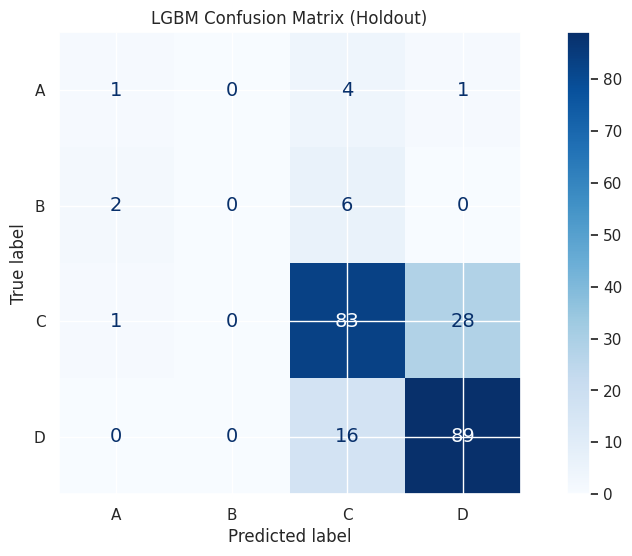

In [22]:
# LGBM
best_lgbm_model.fit(train_X, train_y)
y_pred = best_lgbm_model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred, labels=np.arange(len(encoder.classes_)))
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues')
plt.title("LGBM Confusion Matrix (Holdout)")
plt.show()

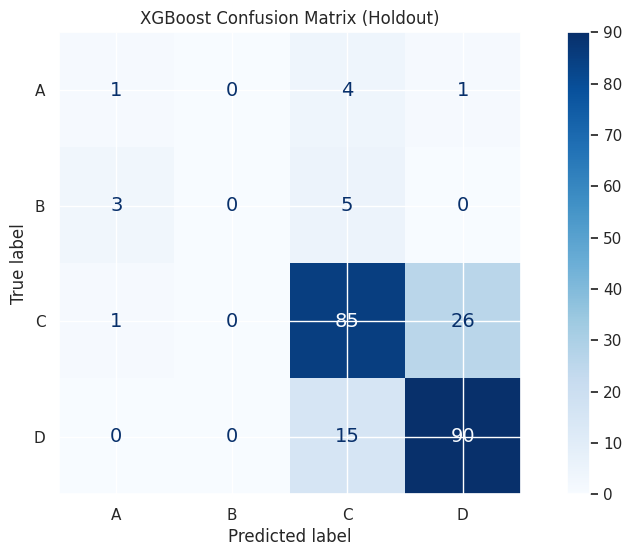

In [23]:
# XGBoost
best_xgb_model.fit(train_X, train_y)
y_pred = best_xgb_model.predict(X_valid)

cm = confusion_matrix(
    y_valid,
    y_pred,
    labels=np.arange(len(encoder.classes_))
)

disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix (Holdout)")
plt.show()

In [24]:
# 최종 모델을 생성하고 전체 데이터를 학습 시킨다.
best_model = XGBClassifier(
    tree_method='gpu_hist',      # [수정] 튜닝과 동일한 GPU 설정
    predictor='gpu_predictor',   # [수정]
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0,
    random_state=42
)
best_model.set_params(**xgboost_grid_clf.best_params_)

# [수정] 최종은 2021~2023 전체로 재학습 (X, y_encoded)
best_model.fit(X, y_encoded)

best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
feature_cols = list(X_raw.columns)
label_order = list(getattr(encoder, 'classes_', []))

save_objects = {
    'model': best_model,
    'encoder': encoder,
    'scaler': scaler1,
    'feature_cols': feature_cols,
    'drop_cols': drop_cols,
    'label_order': label_order,
    'best_params': getattr(xgboost_grid_clf, 'best_params_', None)
}

with open(best_model_path, 'wb') as fp:
    pickle.dump(save_objects, fp, protocol=pickle.HIGHEST_PROTOCOL)

# XGBoost는 JSON도 같이 저장 — 버전 바뀌어도 안전
best_model.get_booster().save_model(best_model_path.replace('.dat', '.json'))

In [26]:
with open(best_model_path, 'rb') as fp:
    loaded = pickle.load(fp)

test_model = loaded['model']
test_encoder = loaded.get('encoder')
test_scaler = loaded.get('scaler')

In [27]:
r1 = test_model.predict(train_X)
r2 = f1_score(train_y, r1, average='macro')  # 또는 'micro'
print("F1 Macro:", r2)

F1 Macro: 0.74155173533812
